# 00 - PRSeismic Overview

This notebook shows the end-to-end `prseismic` API, including image and measurement visualization, metadata interpretation, and sparse-vs-linear-operator usage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['image.cmap'] = 'viridis'
from scipy.sparse import issparse
from pyprseimsic import PhantomType, WaveModel, prseismic

## Quick start problem

In [2]:
N = 64
s = 32
p = 64
prob = prseismic(N=N, s=s, p=p, phantom='tectonic', wave_model='ray')
print('A type:', type(prob.A).__name__)
print('A shape:', prob.A.shape)
print('b shape:', prob.b.shape)
print('x shape:', prob.x.shape)
print('info:', prob.info)
assert issparse(prob.A)


A type: csr_matrix
A shape: (2048, 4096)
b shape: (2048,)
x shape: (4096,)
info: ProblemInfo(problem_type='tomography', x_size=(64, 64), b_size=(64, 32))


## Visualize phantom `x` and measurements `b`

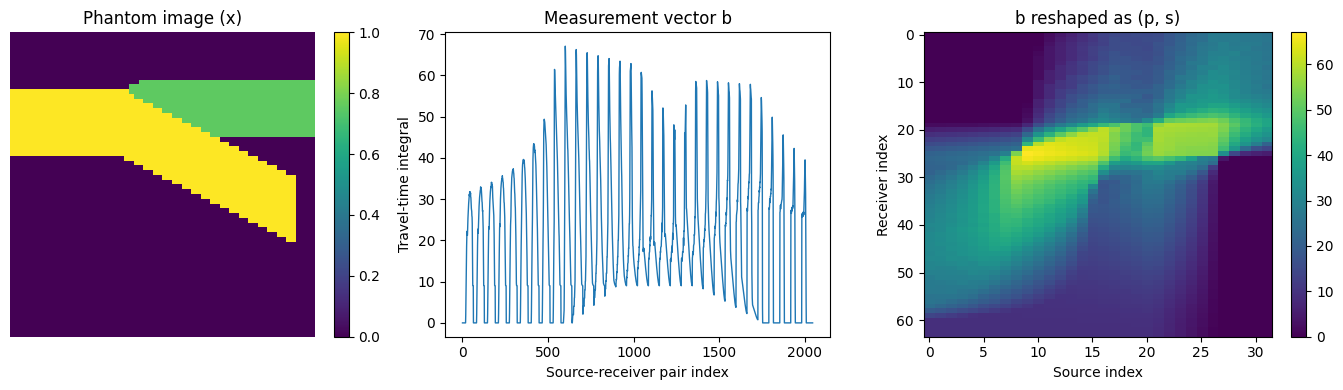

In [3]:
x_img = prob.x.reshape((N, N), order='F')
b_img = prob.b.reshape((p, s), order='F')

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
im0 = axes[0].imshow(x_img, vmin=0, vmax=1)
axes[0].set_title('Phantom image (x)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

axes[1].plot(prob.b, lw=1.0)
axes[1].set_title('Measurement vector b')
axes[1].set_xlabel('Source-receiver pair index')
axes[1].set_ylabel('Travel-time integral')

im2 = axes[2].imshow(b_img, aspect='auto')
axes[2].set_title('b reshaped as (p, s)')
axes[2].set_xlabel('Source index')
axes[2].set_ylabel('Receiver index')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()


## Sanity check: `b = A @ x`

In [4]:
b_check = prob.A @ prob.x
np.testing.assert_allclose(prob.b, b_check, atol=1e-12)
print('Check passed: b equals A @ x (sparse mode).')

Check passed: b equals A @ x (sparse mode).


## Enum inputs and Fresnel model

In [5]:
prob_enum = prseismic(
    N=48,
    phantom=PhantomType.GRAINS,
    wave_model=WaveModel.FRESNEL,
    s=24,
    p=48,
    omega=8.0,
    seed=42,
)
print('Enum-based problem shape:', prob_enum.A.shape)
print('b min/max:', float(prob_enum.b.min()), float(prob_enum.b.max()))


Enum-based problem shape: (1152, 2304)
b min/max: 0.42428364925791007 38.365643665080555


## Custom phantom input

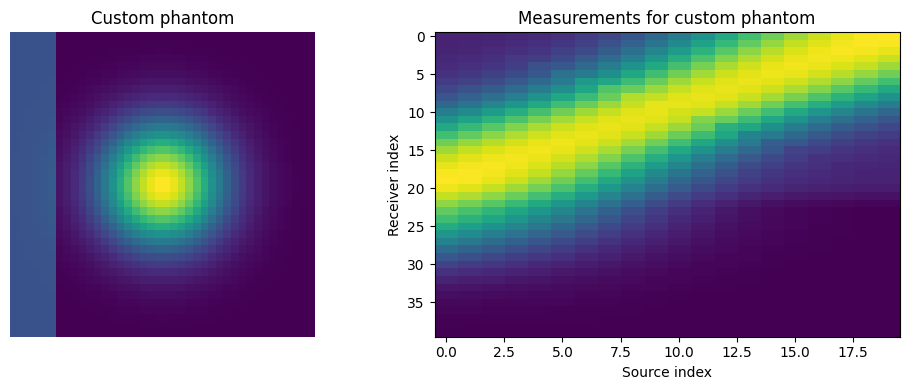

In [6]:
Nc = 40
xx = np.linspace(-1, 1, Nc)
X, Y = np.meshgrid(xx, xx)
custom = np.exp(-6 * (X**2 + Y**2))
custom[:, :6] += 0.25
custom = np.clip(custom / custom.max(), 0, 1)

prob_custom = prseismic(phantom=custom, s=20, p=40, wave_model='ray')
b_custom = prob_custom.b.reshape((40, 20), order='F')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(custom, vmin=0, vmax=1)
axes[0].set_title('Custom phantom')
axes[0].axis('off')

axes[1].imshow(b_custom, aspect='auto')
axes[1].set_title('Measurements for custom phantom')
axes[1].set_xlabel('Source index')
axes[1].set_ylabel('Receiver index')

plt.tight_layout()


## LinearOperator mode

In [7]:
prob_lin = prseismic(48, s=24, p=48, sparse_matrix=False, seed=3)
y = prob_lin.A.matvec(prob_lin.x)
np.testing.assert_allclose(y, prob_lin.b, atol=1e-12)
z = prob_lin.A.rmatvec(prob_lin.b)
print('Check passed: LinearOperator matvec matches b.')
print('rmatvec output shape:', z.shape)
print('||rmatvec(b)||_2:', float(np.linalg.norm(z)))


Check passed: LinearOperator matvec matches b.
rmatvec output shape: (2304,)
||rmatvec(b)||_2: 24911.09831423172
